# Contrasting by Patient Augmented Electrocardiograms (CAPE)
This is a small demo for the classification/regression for PTB-XL labels. The pre-trained model cannot be shared due to data security issues so the features for PTB-XL are obtained using the pre-trained model trained with 6,174,025 ECGS belonging to 1,224,895 subjects. A linear classifier is then trained to predict super and sub classes as well as age and sex of the subject.

Import required libraries ....

In [2]:
#imports
#import sys
import h5py
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
import pandas as pd
import utils as u
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import *
np.random.seed(10)

Define the training configuration. Super and sub classes cannot be used together in targets as different label files are used in each case.

In [3]:
class supervised_training:
    def __init__(self, dataset='ptb', featname = 'CAPE_feats_ptb_bcsv.h5', 
                 resname = 'test', runs=1, ntrain=0, ntest=0, nval=0,
                targets = ['age', 'sex', 'super_classes', 'sub_classes'], tparams=None):
        """
        Supervised trainig configuraion for downstream tasks.
        """
        self.datapath = 'data/ECGdata/' # label location
        self.labels_filename = 'ecg_labels.csv'
        self.dataset = dataset  # label dataset
        self.featname = featname  # name of feature file
        self.featpath = os.path.join('feats', self.dataset, self.featname)
        
        self.datatype = 'rhythm' # type of data
        self.split_path = 'data/DataSplits' # location of splits
        self.outdir = 'results' # result path
        self.res_name = f'MLP_{self.dataset}_{resname}' # result directory
        self.result_dir = os.path.join(self.outdir, self.res_name)
        u.safe_mkdir(self.result_dir)
        print(f'{self.result_dir} generated to save results')
        self.rloss = 'mse' # regression loss
        self.closs = 'binary_crossentropy' # classification loss as multi-label
        self.ractivation = 'linear' # activation for regression output
        self.cactivation = 'sigmoid'# activation for classification output
        self.rmetrics = ['mae', 'r2_score'] # metrics for classification
        self.cmetrics = ['AUC', 'f1_score'] # metrics for regression
        self.rmonitor = 'val_mae' # monitor for regression
        self.cmonitor = 'val_auc' # monitor for classification
        
        #training config
        self.runs = runs
        self.ntrain = ntrain
        self.nval = nval
        self.ntest = ntest
        self.targets = targets
        self.target_labels = self.targets if isinstance(self.targets, list) else [self.targets]
        self.class_names = {}
        for target in self.target_labels:
            if target in ['gender', 'female']:
                self.class_names[target] = ['MALE', 'FEMALE']
            else:
                self.class_names[target] = [0, 1]
        self.data_info = u.get_data_info()
        self.data_info['path']['ptb']='ptb'
        self.datadir = os.path.join(self.datapath, self.data_info['path'][self.dataset])
        self.train_split =  self.data_info['split'][self.dataset]['train']
        self.val_split =  self.data_info['split'][self.dataset]['val']
        self.test_split =  self.data_info['split'][self.dataset]['test']

        self.training_type = {}
        for target in self.target_labels:
            self.training_type[target] = 'regression' if 'age' in target else 'classification'

        self.task = {}
        self.task['classification'] = {}
        self.task['classification']['metrics'] = self.cmetrics
        self.task['classification']['loss'] = self.closs
        self.task['classification']['activation'] = self.cactivation
        self.task['classification']['monitor'] = self.cmonitor
        self.task['regression'] = {}
        self.task['regression']['metrics'] = self.rmetrics
        self.task['regression']['loss'] = self.rloss
        self.task['regression']['activation'] = self.ractivation
        self.task['regression']['monitor'] = self.rmonitor

        #training params
        if tparams: self.tparams = tparams
        else:
            self.tparams = {}
            self.tparams['age'] = {}
            self.tparams['age']['lr'] =0.005
            self.tparams['age']['epochs'] = 100
            self.tparams['age']['hidden'] = []
            self.tparams['age']['use_weights'] = 0
            self.tparams['age']['class_weights'] = 0
            self.tparams['age']['opt_decay'] = 0.1
            self.tparams['age']['opt_epochs'] = 10

            self.tparams['sex'] = {}
            self.tparams['sex']['lr'] =0.005
            self.tparams['sex']['epochs'] = 100
            self.tparams['sex']['hidden'] = []
            self.tparams['sex']['use_weights'] = 1
            self.tparams['sex']['class_weights'] = 0
            self.tparams['sex']['opt_decay'] = 0.1
            self.tparams['sex']['opt_epochs'] = 10

            self.tparams['sub_classes'] = {}
            self.tparams['sub_classes']['lr'] =0.0001
            self.tparams['sub_classes']['epochs'] = 300
            self.tparams['sub_classes']['hidden'] = []
            self.tparams['sub_classes']['use_weights'] = 0
            self.tparams['sub_classes']['class_weights'] = 0
            self.tparams['sub_classes']['opt_decay'] = 0.5
            self.tparams['sub_classes']['opt_epochs'] = 5

            self.tparams['super_classes'] = {}
            self.tparams['super_classes']['lr'] = 0.0001
            self.tparams['super_classes']['epochs'] = 300
            self.tparams['super_classes']['hidden'] = []
            self.tparams['super_classes']['use_weights'] = 0
            self.tparams['super_classes']['class_weights'] = 0
            self.tparams['super_classes']['opt_decay'] = 0.5
            self.tparams['super_classes']['opt_epochs'] = 5
        
    def get_ptb_classes(self, name):
        if name=='sub':
            sub_classes =['NORM', 'IMI', 'STTC', 'NST_', 'LVH','LAFB/LPFB', 'RVH', 
                          'RAO/RAE', 'IRBBB', 'IVCD', 'LMI', 'AMI', '_AVB', 'ISCA', 
                          'SEHYP', 'ISCI', 'ISC_', 'CRBBB', 'CLBBB', 'LAO/LAE', 'ILBBB', 'PMI', 'WPW']
            return sub_classes
        if name=='super':
            super_classes = ['NORM','MI', 'STTC', 'CD', 'HYP']
            return super_classes

    def get_ids(self):
        idx_train = pd.read_csv(os.path.join(self.split_path, self.dataset, self.train_split), usecols=[self.data_info['filename'][self.dataset]])
        idx_val = pd.read_csv(os.path.join(self.split_path, self.dataset, self.val_split), usecols=[self.data_info['filename'][self.dataset]])
        idx_test = pd.read_csv(os.path.join(self.split_path, self.dataset, self.test_split), usecols=[self.data_info['filename'][self.dataset]])

        if not self.ntrain: self.ntrain = len(idx_train)
        if not self.nval: self.nval = len(idx_val)
        if not self.ntest: self.ntest = len(idx_test)
        print(f'train samples from {self.split_path}/{self.dataset}/{self.train_split} = {self.ntrain}')
        print(f'val samples from {self.split_path}/{self.dataset}/{self.val_split} = {self.nval}')
        print(f'test samples from {self.split_path}/{self.dataset}/{self.test_split} = {self.ntest}')
        return idx_train, idx_val, idx_test

    def get_labels(self): 
        data_dir = os.path.join(self.datapath, self.data_info['path'][self.dataset])
        print(f'reading labels from {data_dir}')   
        # read ecg labels     
        df = pd.read_csv(os.path.join(data_dir, self.labels_filename))
        print(f'labels found at {data_dir}/{self.labels_filename} = {list(df.keys())}')
        return df

    def shuffle(self, arr):
        np.random.shuffle(arr)
        return arr

    def get_indices(self, df, id_split, id_key, num):
        indices = np.sort(self.shuffle(u.get_indices_from_ids(df, id_split[id_key], id=id_key))[:num])
        return indices
    
    
    def train_mlp(self):
        idx_train, idx_val, idx_test = self.get_ids()
        df = self.get_labels()
        train_indices = self.get_indices(df, idx_train, self.data_info['filename'][self.dataset], self.ntrain)
        val_indices = self.get_indices(df, idx_val, self.data_info['filename'][self.dataset], self.nval)
        test_indices = self.get_indices(df, idx_test, self.data_info['filename'][self.dataset], self.ntest)
        print(f' Total size =', len(df))
        print(f' train size ={len(train_indices)}')
        print(f' val size ={len(val_indices)}')
        print(f' test size ={len(test_indices)}')
        if 'h5' in self.featpath:
           print('reading h5 data')
           hf = h5py.File(self.featpath, 'r') 
           X_train = np.array(hf.get('feats')[train_indices])
           X_val = np.array(hf.get('feats')[val_indices])
           X_test = np.array(hf.get('feats')[test_indices])
        elif 'csv' in self.featpath:
           print('reading csv')
           hf = pd.read_csv(self.featpath, index_col=False)
           X_train = np.array(hf)[train_indices]
           X_val = np.array(hf)[val_indices]
           X_test = np.array(hf)[test_indices]

        print(f'features are loaded from {self.featpath} with shapes = {X_train.shape[1:]}')
        # normalization
        meanf = np.expand_dims(np.mean(X_train, axis=0), axis=0)
        stdf = np.expand_dims(np.std(X_train, axis=0), axis=0)
        norm_dir = os.path.join(self.result_dir, 'normalization_params')
        u.safe_mkdir(norm_dir)
        np.save(os.path.join(norm_dir, 'data_mean.npy'), meanf)
        np.save(os.path.join(norm_dir, 'data_std.npy'), stdf)

        X_train = np.where(stdf>0, (X_train - meanf)/stdf, 0)
        X_val = np.where(stdf>0, (X_val - meanf)/stdf, 0)
        X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)
        in_shape = (X_train.shape[1],)
        out_shape = (None, )
        score ={}
        for label in self.target_labels:
            df_label = pd.DataFrame()
            label_dir = os.path.join(self.result_dir, label.replace("/", "_"))
            u.safe_mkdir(label_dir)

            dlabel = self.data_info[label][self.dataset] if label in self.data_info else label
            if dlabel=='gender':
               for i, class_name in enumerate(df[dlabel].unique()):
                 df.loc[df[dlabel] == class_name, dlabel] = i
            if label in ['super_classes', 'sub_classes']:
                if label == 'super_classes': 
                   dlabel = self.get_ptb_classes('super')
                   df = pd.read_csv(os.path.join(self.datadir, 'super_labels.csv'))
                elif label == 'sub_classes': 
                   dlabel = self.get_ptb_classes('sub')
                   df = pd.read_csv(os.path.join(self.datadir, 'sub_labels.csv'))

                num_classes = len(dlabel)
            else:
                num_classes = 1

            y_train = np.array(df[dlabel])[train_indices].astype(np.float32)
            y_val = np.array(df[dlabel])[val_indices].astype(np.float32)
            y_test = np.array(df[dlabel])[test_indices].astype(np.float32)

            train_type = self.training_type[label]
            metrics = self.task[train_type]['metrics']
            loss = self.task[train_type]['loss']
            activation = self.task[train_type]['activation']
            monitor = self.task[train_type]['monitor']

            score[label] = {}
            multilabel_metrics = ['macro_auc', 'micro_auc', 'macro_f1score', 'acc', 'wt_acc']
            t_metrics = multilabel_metrics if num_classes>1 else metrics
            for metric in t_metrics:
                score[label][metric] = []

            if (label=='age'):
                maxl = 107 #np.max(y_train)
                minl = 7 #np.min(y_train)
                print(f'normalized by min {label} = {minl} and max {label} = {maxl}')
                if self.dataset == 'ptb':
                  y_train[y_train>90] = 95
                  y_val[y_val>90] = 95
                  y_test[y_test>90] = 95
                y_train = (y_train - minl)/(maxl- minl)
                y_val = (y_val - minl)/(maxl- minl)
                y_test = (y_test - minl)/(maxl- minl)

            if ('mae' in monitor) or ('loss' in monitor):
                choose = 'min'
            else:
                choose = 'max'

            param_label = label if label in self.tparams else 'class'

            print(f'Number of training instances: {len(X_train)}')
            print(f'Number of validation instances: {len(X_val)}')
            print(f'Number of test instances: {len(X_test)}')

            for run in np.arange(self.runs):
                 print(f'RUN {run+1} / {self.runs}')
                 run_dir = os.path.join(label_dir, f'run{run+1}')
                 u.safe_mkdir(run_dir)
                 # Create Model

                 ecg_model = u.build_linear_probe(input_shape=in_shape, out_size=num_classes, out_activation=activation)
                 # Compile Model

                 opt = tf.keras.optimizers.Adam(learning_rate=self.tparams[param_label]['lr'])
                 if self.tparams[param_label]['class_weights']:
                     class_weights = []
                     for i in range(num_classes):
                         class_weights.append(y_train.shape[0] / (np.sum(y_train[:, i]) * num_classes))
                 else:
                     class_weights = None
                 ecg_model.compile(loss=[loss]*num_classes, loss_weights=class_weights,  metrics= metrics[:-1], optimizer=opt)

                 model_checkpoint_callback = ModelCheckpoint(filepath=os.path.join(run_dir, 'best_model'),
                                            monitor=monitor,
                                            mode=choose,
                                            save_best_only=True,
                                            save_weights_only=True)
                 model_early_stopping = EarlyStopping(monitor=monitor, mode =choose, min_delta=0.0001, patience=30)
                 model_reduce_lr = ReduceLROnPlateau(patience=self.tparams[param_label]['opt_epochs'], factor=self.tparams[param_label]['opt_decay'])

                 # Model Training
                 if self.tparams[param_label]['use_weights']:
                    X_weights = compute_sample_weight( class_weight="balanced", y=y_train)
                 else:
                    X_weights = None

                 init = time.time()
                 print('Training ......')
                 history_obj = ecg_model.fit(X_train, y_train,
                                    sample_weight=X_weights,
                                    validation_data=(X_val, y_val),
                                    batch_size=64,
                                    epochs=self.tparams[param_label]['epochs'],
                                    shuffle=True,
                                    verbose=0,
                                    callbacks = [model_checkpoint_callback, model_early_stopping,model_reduce_lr])
                 training_time = (time.time()-init)/self.tparams[param_label]['epochs']

                 history = history_obj.history         
                 u.plot_loss(history['loss'], history['val_loss'], loss, run_dir)
                 ecg_model.load_weights(filepath=os.path.join(run_dir, 'best_model'))

                 # Model Evaluation
                 val_metrics = ecg_model.evaluate(X_val, y_val, batch_size=64, verbose=0)

                 # Get Validation Metrics and History
                 val_metrics = dict(zip([('val_' + metric) for metric in ecg_model.metrics_names], val_metrics))
                 print(f'label = {label}')
                 print('val_metrics', val_metrics)
                 if run==0:
                    df_val = pd.DataFrame(val_metrics, index=[run])
                 else:
                    df_val = pd.concat([df_val, pd.DataFrame(val_metrics, index=[run])], ignore_index=True)

                 for m in metrics[:1]:
                   if m=='AUC': m = 'auc'
                   u.plot_loss(history[m], history[f'val_{m}'], m, run_dir)
                 #testing
                 # Model Prediction
                 init = time.time()
                 y_pred = np.squeeze(ecg_model.predict(X_test,
                                   batch_size=64))
                 inference_time = (time.time()-init)/y_pred.shape[0]
                 test_metrics = ecg_model.evaluate(X_test, y_test, batch_size=64)
                 test_metrics = dict(zip([('test_' + metric) for metric in ecg_model.metrics_names], test_metrics))
                 print('test_metrics', test_metrics)
                 y_test, y_pred= np.squeeze(y_test), np.squeeze(y_pred)

                 if (train_type == 'regression') and label=='age':           
                   y_test = minl + (y_test * (maxl-minl))
                   y_pred = minl + (y_pred * (maxl-minl))
                   #mae_age = np.mean(np.absolute(y_test_age - y_pred_age))
                   if self.dataset == 'ptb':
                        ind = y_test<95
                        y_test = y_test[ind]
                        y_pred = y_pred[ind]

                   result = u.get_regression_metrics(y_test, y_pred, t_metrics) 

                 else:
                    if num_classes == 1:
                        result = u.get_class_metrics(y_test, y_pred, t_metrics)
                    else:
                        result = u.get_multiclass_metrics(y_test, y_pred, t_metrics, num_classes)
                 if run==0: df_label[f'true_{label}'] = list(y_test)
                 df_label[f'pred_{label}_run_{run}'] = list(y_pred)
                 for m in t_metrics:
                    score[label][m].append(result[m])
           
            lines=[]
            u.myprint(lines, '==========================================')
            u.myprint(lines, f'==============  {label} =================')
            u.myprint(lines, '==========================================')
            for m in score[label]:
               metric = np.array(score[label][m])
               u.myprint(lines, f'The {m} are {metric}')
               u.myprint(lines, f'The mean for {self.runs} runs = {np.mean(metric):0.4f} and the std = {np.std(metric):0.4f}')
            u.myprint(lines, f'The training time = {training_time:0.4f}/epoch and the inference time = {inference_time:0.4f}/ecg')
            u.myprint(lines, '==========================================')
            u.myprint(lines, '========  Training Configuration =========')
            u.myprint(lines, '==========================================')
            lines = u.get_class_config(self, lines)
            arch = ['Architecture Summary \n']
            ecg_model.summary(print_fn=lambda x: arch.append(x + '\n'))
            lines = lines + ['\n'] + arch
            training_params = self.tparams[param_label]
            lines = lines + ['\n'] + [f'Training params: {training_params}']
            u.to_file(lines, os.path.join(label_dir, 'summary.txt'))
            df_val.to_csv(os.path.join(label_dir, f'val_metrics.csv'), index=False)
            df_label.to_csv(os.path.join(label_dir, f'predictions_{label}.csv'), index=False)
            df_score = pd.DataFrame()
            for m in score[label]:
               df_score[m] = np.array(score[label][m])
            df_score.to_csv(os.path.join(self.result_dir, f'score_{label.replace("/", "_")}.csv'))

In [4]:
my_training = supervised_training(featname = 'CAPE_feats_BTCSV_IDB_PTBXL.h5', resname='test_btcsv')

results/MLP_ptb_test_btcsv generated to save results


train samples from data/DataSplits/ptb/ptb_train_split.csv = 17418
val samples from data/DataSplits/ptb/ptb_val_split.csv = 2183
test samples from data/DataSplits/ptb/ptb_test_split.csv = 2198
reading labels from data/ECGdata/ptb
labels found at data/ECGdata/ptb/ecg_labels.csv = ['filename_lr', 'filename_hr', 'strat_fold', 'patient_id', 'age', 'sex', 'recording_date', 'MI', 'STTC', 'HYP', 'CD']
 Total size = 21799
 train size =17418
 val size =2183
 test size =2198
reading h5 data
features are loaded from feats/ptb/CAPE_feats_BTCSV_IDB_PTBXL.h5 with shapes = (256,)
normalized by min age = 7 and max age = 107
Number of training instances: 17418
Number of validation instances: 2183
Number of test instances: 2198
RUN 1 / 1


/var/tmp/pbs.1475247.pbs/ipykernel_1971155/3743220000.py:178: RuntimeWarning: invalid value encountered in divide
  X_train = np.where(stdf>0, (X_train - meanf)/stdf, 0)
/var/tmp/pbs.1475247.pbs/ipykernel_1971155/3743220000.py:179: RuntimeWarning: invalid value encountered in divide
  X_val = np.where(stdf>0, (X_val - meanf)/stdf, 0)
/var/tmp/pbs.1475247.pbs/ipykernel_1971155/3743220000.py:180: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


Training ......
label = age
val_metrics {'val_loss': 0.009560097008943558, 'val_mae': 0.07732829451560974}
35/35 [==============================] - 0s 487us/step - loss: 0.0099 - mae: 0.0786
test_metrics {'test_loss': 0.009899036958813667, 'test_mae': 0.07861807942390442}
==============  age =================
The mae are [7.682991]
The mean for 1 runs = 7.6830 and the std = 0.0000
The r2_score are [0.68667859]
The mean for 1 runs = 0.6867 and the std = 0.0000
The training time = 0.1050/epoch and the inference time = 0.0001/ecg
========  Training Configuration =========
Number of training instances: 17418
Number of validation instances: 2183
Number of test instances: 2198
RUN 1 / 1
Training ......
label = sex
val_metrics {'val_loss': 0.30319833755493164, 'val_auc': 0.9456150531768799}
35/35 [==============================] - 0s 513us/step - loss: 0.3278 - auc: 0.9364
test_metrics {'test_loss': 0.32781514525413513, 'test_auc': 0.9364400506019592}
==============  sex =================
The

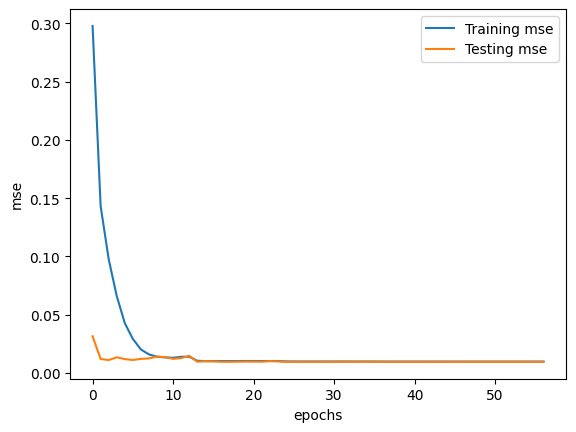

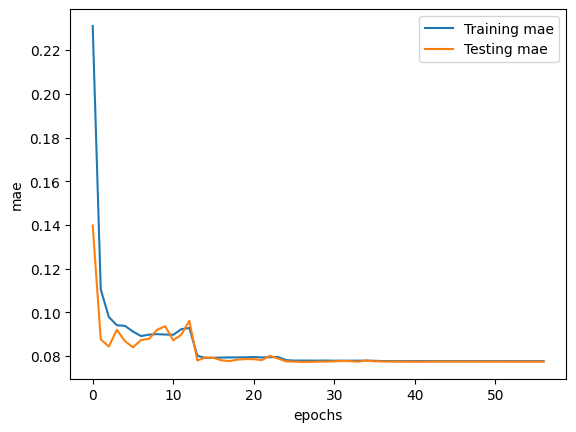

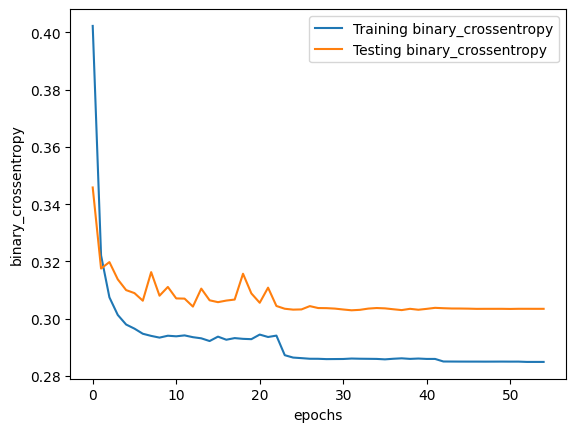

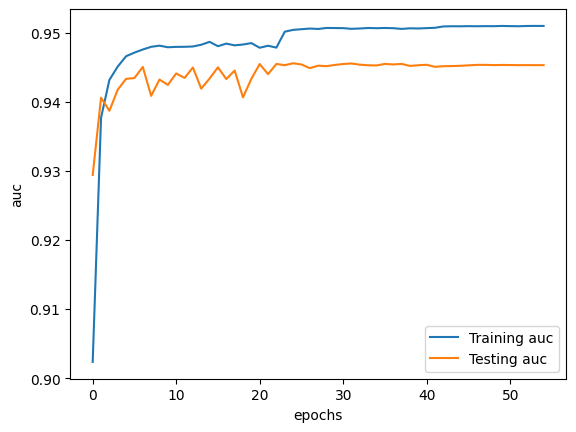

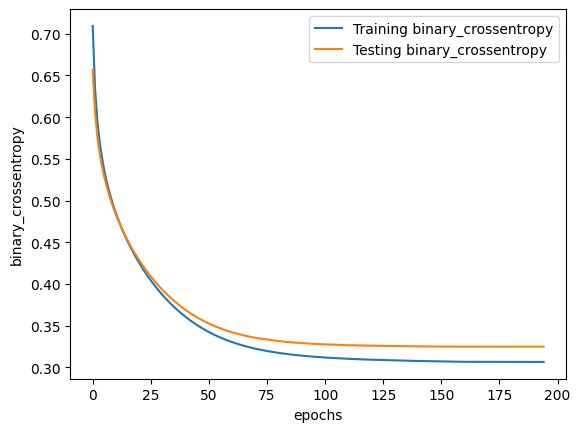

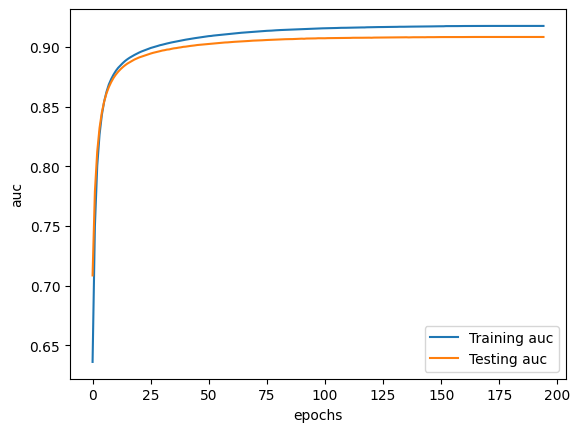

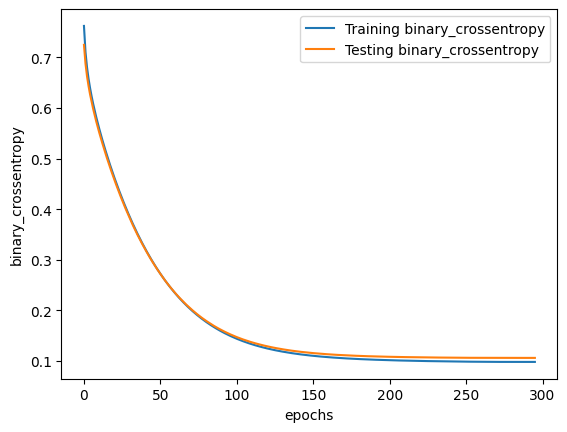

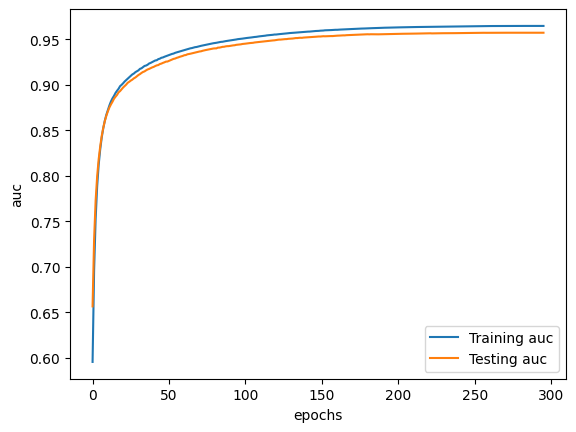

In [5]:
my_training.train_mlp()